In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix


In [ ]:
# Load dataset
data = pd.read_csv("/content/dataset_full (1).csv")
print("Dataset shape:", data.shape)
print(data.head())

# Drop NaN values and duplicates
data = data.dropna().drop_duplicates()

# Convert boolean columns to integers
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

# Normalize numerical columns
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

# Save the scalers for future use
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")

# Save the preprocessed dataset
data.to_csv("newphishdata.csv", index=False)


Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# Split dataset into features and target variable
X = data.drop(columns=['phishing'])
y = data['phishing']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Reshape data for DBN (samples, features)
X_train_dbn = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1])
X_test_dbn = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1])


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class NeuralFieldAttention(layers.Layer):
    def __init__(self, lambda_strength=0.1, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super().build(input_shape)

    def call(self, inputs):
        I = inputs  # [batch_size, feature_dim]
        u = tf.zeros_like(I)

        # Precompute mean to avoid dynamic operations
        I_mean = tf.reduce_mean(I, axis=1, keepdims=True)
        delta = tf.reduce_mean(tf.abs(I - I_mean), axis=-1, keepdims=True)
        delta = tf.tile(delta, [1, I.shape[-1]])

        # Apply interaction and attention
        interaction = tf.matmul(I, self.kernel)
        activation = tf.nn.relu(u)
        u = u + (-u + interaction + I + self.lambda_strength * delta)

        # Apply attention scores and compute attended output
        attention_scores = tf.nn.softmax(u, axis=1)
        attended_output = tf.reduce_sum(attention_scores * I, axis=1)

        return attended_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "lambda_strength": self.lambda_strength
        })
        return config


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the custom NeuralFieldAttention layer
class NeuralFieldAttention(tf.keras.layers.Layer):
    def __init__(self, lambda_strength=0.1, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super().build(input_shape)

    def call(self, inputs):
        I = inputs  # [batch_size, feature_dim]
        u = tf.zeros_like(I)

        # Precompute mean to avoid dynamic operations
        I_mean = tf.reduce_mean(I, axis=1, keepdims=True)
        delta = tf.reduce_mean(tf.abs(I - I_mean), axis=-1, keepdims=True)
        delta = tf.tile(delta, [1, I.shape[-1]])

        # Apply interaction and attention
        interaction = tf.matmul(I, self.kernel)
        activation = tf.nn.relu(u)
        u = u + (-u + interaction + I + self.lambda_strength * delta)

        # Apply attention scores and compute attended output
        attention_scores = tf.nn.softmax(u, axis=1)
        attended_output = tf.reduce_sum(attention_scores * I, axis=1)

        return attended_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "lambda_strength": self.lambda_strength
        })
        return config

# Build DBN Model with Attention
dbn_model = Sequential()

# Add input layer (input shape for DBN, e.g., feature_dim)
dbn_model.add(Input(shape=(X_train.shape[1],)))

# Fully connected layers (DBN part)
dbn_model.add(Dense(128, activation='relu'))
dbn_model.add(Dropout(0.2))
dbn_model.add(Dense(64, activation='relu'))
dbn_model.add(Dropout(0.2))
dbn_model.add(Dense(32, activation='relu'))
dbn_model.add(Dropout(0.2))

# Add Neural Field Attention after the first feature extraction
dbn_model.add(NeuralFieldAttention(lambda_strength=0.2))

# Reshape the output of Neural Field Attention to have shape (None, 1)
dbn_model.add(tf.keras.layers.Reshape((1,)))

# Fully connected layers after attention mechanism
dbn_model.add(Dense(128, activation='relu'))
dbn_model.add(Dropout(0.3))
dbn_model.add(Dense(64, activation='relu'))
dbn_model.add(Dropout(0.2))

# Output layer
dbn_model.add(Dense(1, activation='sigmoid'))

# Compile model
dbn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

dbn_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ neural_field_attention          │ (None)                 │         1,024 │
│ (NeuralFieldAttention)          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,273 (133.88 KB)

 Trainable params: 34,273 (133.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} Time: {epoch_times[-1]:.2f}s")

time_callback = tf.keras.callbacks.LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)



In [ ]:
# Train the DBN model
history = dbn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, time_callback],
    verbose=1
)



Epoch 1/50
1085/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9219 - Precision: 0.7888 - Recall: 0.8256 - accuracy: 0.8656 - loss: 0.3393Epoch 1 Time: 12.94s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - AUC: 0.9221 - Precision: 0.7891 - Recall: 0.8260 - accuracy: 0.8658 - loss: 0.3388 - val_AUC: 0.9800 - val_Precision: 0.9148 - val_Recall: 0.8578 - val_accuracy: 0.9224 - val_loss: 0.1931
Epoch 2/50
1090/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9759 - Precision: 0.8752 - Recall: 0.9140 - accuracy: 0.9241 - loss: 0.1875Epoch 2 Time: 6.59s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.9759 - Precision: 0.8752 - Recall: 0.9140 - accuracy: 0.9241 - loss: 0.1875 - val_AUC: 0.9815 - val_Precision: 0.8736 - val_Recall: 0.9402 - val_accuracy: 0.9315 - val_loss: 0.1698
Epoch 3/50
1086/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9774 - Precision: 0.8751 - Recall: 0.9168 - accuracy: 0.9248 - loss: 0.1812Epoch 3 Time: 10.44s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.9774

In [ ]:
y_pred = (dbn_model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# FAR & FRR
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Metrics:
Accuracy: 0.9552
Precision: 0.9298
Recall: 0.9431
AUC: 0.9524
Confusion Matrix:
[[10909   434]
 [  347  5752]]

FAR: 0.0383
FRR: 0.0569


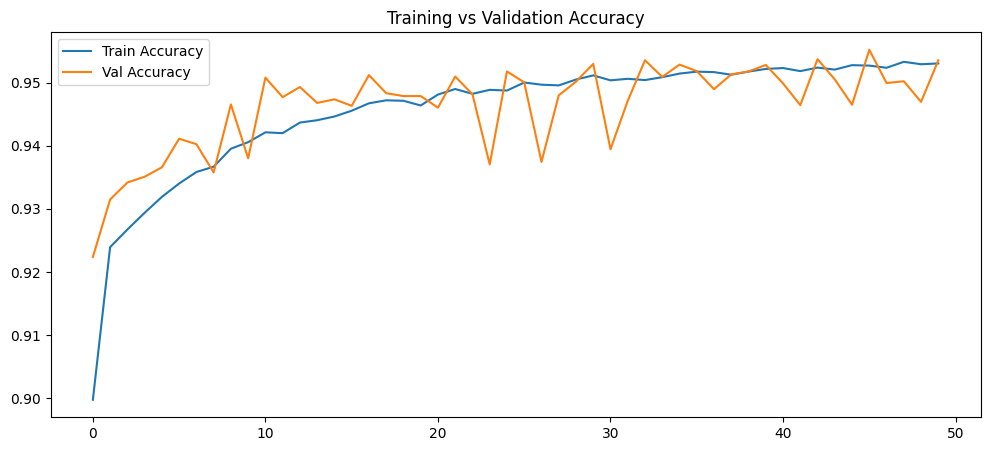

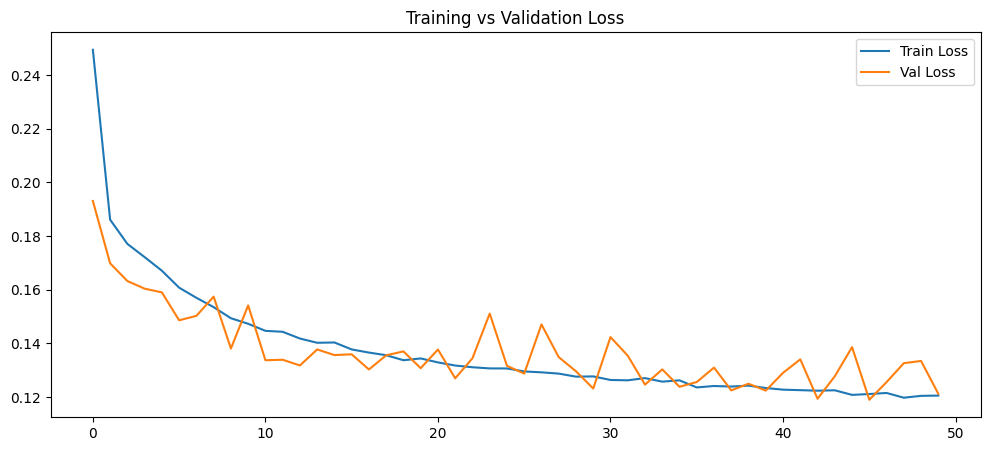

In [ ]:
np.save("model_history_dbn.npy", history.history)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()


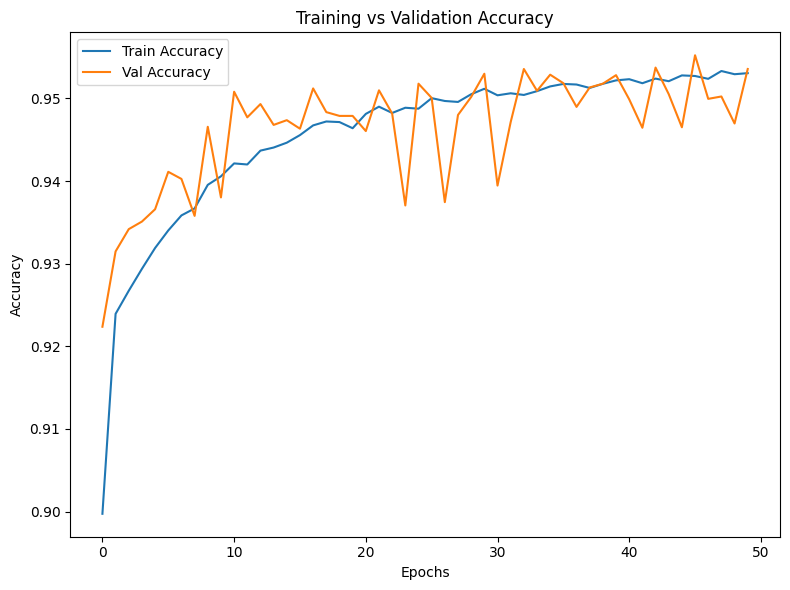

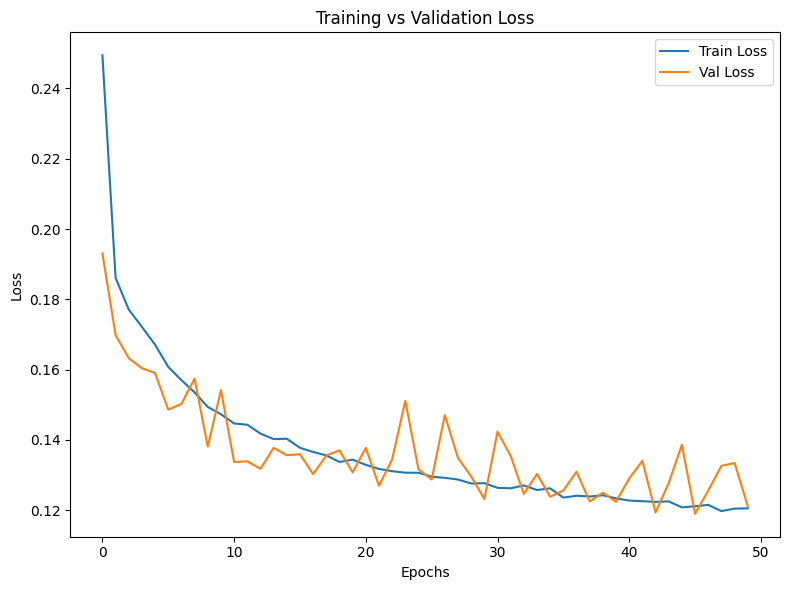

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Save model history
np.save("model_history_dbn.npy", history.history)

# Plot Accuracy (smaller figure, square-ish ratio)
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Loss (smaller figure, square-ish ratio)
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
pip install tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
pip install python-whois

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 1.6 MB/s eta 0:00:00


In [ ]:
pip install dnspython


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
import re
import socket
import requests
from urllib.parse import urlparse
import tldextract

def extract_url_features(url):
    features = {}

    parsed = urlparse(url)
    hostname = parsed.hostname or ""
    path = parsed.path or ""
    ext = tldextract.extract(url)
    domain = ext.domain + '.' + ext.suffix if ext.suffix else ext.domain

    # Basic lexical features
    features['url_length'] = len(url)
    features['hostname_length'] = len(hostname)
    features['path_length'] = len(path)
    features['count_dot'] = url.count('.')
    features['count_hyphen'] = url.count('-')
    features['count_slash'] = url.count('/')
    features['count_question'] = url.count('?')
    features['count_equal'] = url.count('=')
    features['count_at'] = url.count('@')
    features['count_ampersand'] = url.count('&')
    features['count_hash'] = url.count('#')
    features['count_percent'] = url.count('%')
    features['count_digits'] = sum(c.isdigit() for c in url)
    features['count_letters'] = sum(c.isalpha() for c in url)

    # Special token presence
    features['has_ip'] = int(bool(re.match(r"^\d{1,3}(\.\d{1,3}){3}$", hostname)))
    features['has_https'] = int("https" in url.lower())
    features['has_http'] = int("http" in url.lower())

    # Domain-based features (examples)
    try:
        ip = socket.gethostbyname(hostname)
        features['domain_in_ip'] = 1 if domain in ip else 0
    except:
        features['domain_in_ip'] = 0

    # Placeholder for some boolean flags
    features['email_in_url'] = int('mailto:' in url)
    features['server_client_domain'] = 0  # Needs additional logic
    features['tld_present_params'] = int(ext.suffix in path)
    features['domain_spf'] = 0  # Needs DNS lookup logic
    features['tls_ssl_certificate'] = 1 if parsed.scheme == 'https' else 0
    features['url_google_index'] = 0  # Needs Google API
    features['domain_google_index'] = 0  # Needs Google API
    features['url_shortened'] = int(bool(re.search(r"(bit\.ly|goo\.gl|tinyurl\.com|ow\.ly)", url)))

    # Fill remaining with zeros (if needed to reach 111)
    while len(features) < 111:
        features[f'padding_{len(features)}'] = 0

    return features


In [ ]:
def predict_from_url(url, model):
    features = extract_url_features(url)
    processed = preprocess_features(features)
    processed = processed.reshape(1, -1)  # Shape (1, 111) for DBN

    pred_prob = model.predict(processed)[0][0]
    pred_class = 1 if pred_prob > 0.5 else 0

    return {
        "url": url,
        "prediction": "Phishing" if pred_class == 1 else "Legitimate",
        "probability": float(pred_prob)
    }


In [ ]:
# Example URL to test
url_to_test = "http://example-login-security.com/login.php"

# Run prediction
result = predict_from_url(url_to_test, dbn_model)

# Print result
print("URL:", result['url'])
print("Prediction:", result['prediction'])
print("Phishing Probability:", result['probability'])


NameError: name 'preprocess_features' is not defined